# Netflix recommendations

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

## Boilerplate

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.11.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

## Imports and constants

In [14]:
import altair as alt
alt.renderers.enable('mimetype')
import pandas as pd

from datetime import timedelta

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

In [3]:
MODEL = "sentence-transformers/paraphrase-MiniLM-L3-v2"
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-netflix-shows-dataset/titles.csv"

## Explore dataset

In [4]:
movie_df = pd.read_csv(DATASET_URL)
movie_df = movie_df[["description", "genres", "title", "release_year"]].drop_duplicates(subset=["description"]).dropna(how='any')
movie_df['id'] = movie_df["description"].map(hash)
movie_df["genres"] = movie_df["genres"].apply(lambda x: " ".join(eval(x)))
movie_df["timestamp"] = [pd.Timestamp(year=year, month=1, day=1).timestamp() for year in movie_df["release_year"].tolist()]
movie_df.head()

,description,genres,title,release_year,id,timestamp
0,This collection includes 12 World War II-era p...,documentation,Five Came Back: The Reference Films,1945,1461244146253042980,-788918400.0
1,A mentally unstable Vietnam War veteran works ...,drama crime,Taxi Driver,1976,5676048700770171589,189302400.0
2,Intent on seeing the Cahulawassee River before...,drama action thriller european,Deliverance,1972,-8590810839608206699,63072000.0
3,"King Arthur, accompanied by his squire, recrui...",fantasy action comedy,Monty Python and the Holy Grail,1975,889510029284069589,157766400.0
4,12 American military prisoners in World War II...,war action,The Dirty Dozen,1967,-6358359510976671764,-94694400.0


## Set up Superlinked

In [5]:
@schema
class MovieSchema:
    description: String
    title: String
    release_timestamp: Timestamp
    genres: String
    id: IdField

In [6]:
movie = MovieSchema()

In [7]:
description_space = TextSimilaritySpace(text=movie.description, model=MODEL)
title_space = TextSimilaritySpace(text=movie.title, model=MODEL)
genre_space = TextSimilaritySpace(text=movie.genres, model=MODEL)
recency_space = RecencySpace(timestamp=movie.release_timestamp, period_time_list=[
    PeriodTime(timedelta(days=4 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=10 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=40 * YEAR_IN_DAYS))],
    negative_filter=-0.25)

In [8]:
movie_index = Index(spaces=[description_space, title_space, genre_space, recency_space])

In [9]:
query_text_param = Param("query_text")

simple_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, query_text_param)
    .similar(title_space.text, query_text_param)
    .similar(genre_space.text, query_text_param)
    .limit(10)
)

advanced_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, Param("description_query_text"))
    .similar(title_space.text, Param("title_query_text"))
    .similar(genre_space.text, Param("genre_query_text"))
    .limit(10)
)

In [10]:
df_parser = DataFrameParser(schema=movie, mapping={movie.release_timestamp: "timestamp"})

In [11]:
source: InMemorySource = InMemorySource(movie, parser=df_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source], indices=[movie_index])
app: InMemoryApp = executor.run()

This next one might take several minutes to run. Getting a coffee or water, or doing a quick planking workout is advised.

In [12]:
source.put([movie_df])

## Understanding recency

Recency can seem quite complex at first, let's see how the score looks like for the relevant time periods

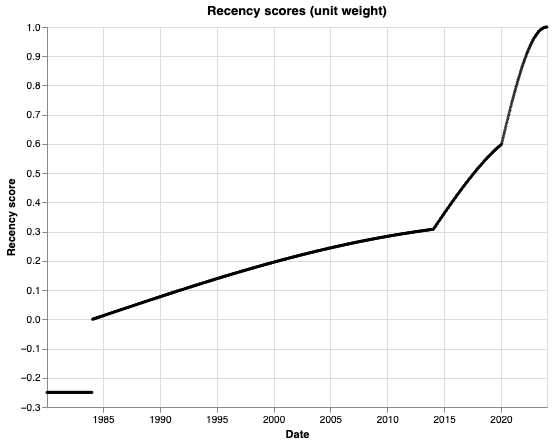

In [15]:
recency_plotter = RecencyPlotter(recency_space)
chart = recency_plotter.plot_recency_curve()
chart

notice the breaks in the score at 4, 10 and 40 years - those are our period times. Titles older than 40 years get `negative_filter` score.

## Run queries

### Queries

With the simple query, I can search with my text in all of the fields

In [16]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      'Love Actually' follows the lives of eight ver...   
2      Two young kids fall in love with each other. B...   
3      When a group of people meets at the same party...   
4      A young woman develops romantic feelings for h...   
5      Love You, is a 2011 Taiwanese drama starring J...   
6      Laida Magtalas is a modern-day Belle who works...   
7      Christina's love life is stuck in neutral. Aft...   
8      Mike Birbiglia shares a lifetime of romantic b...   
9      Two talented song-and-dance men team up after ...   
10     Romantic anthology web series revolving around...   

                             genres  \
order                                 
1              drama comedy romance   
2                     romance drama   
3                    comedy romance   
4                    comedy romance   
5              comedy drama romance   
6              comedy drama romance   
7                    comedy romance   
8      comedy documentation romance   
9                    romance comedy   
10                    drama romance   

                                           title  release_year  
order                                                           
1                                  Love Actually          2003  
2                                   Endless Love          1981  
3                          Love, Surreal and Odd          2017  
4                                Must Be... Love          2013  
5                            Drunken to Love You          2011  
6                            A Very Special Love          2008  
7                             The Sweetest Thing          2002  
8      Mike Birbiglia: My Girlfriend's Boyfriend          2013  
9                                White Christmas          1954  
10                                    Love Daily          2018

After looking at the results, I see some titles I have already seen. I can bias towards recent titles by upweighting recency. Weights are normalised to have unit sum, so you don't have to worry about how you set them.

In [18]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=3
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      In this romantic comedy, several friends, each...   
2      Fidelity tells a story of marital fidelity, in...   
3      This black humor pan-Arabic anthology series i...   
4      A relatable romance drama about a couple in th...   
5      An ad executive and a fashion designer-blogger...   
6      Often (mis)guided by a cheeky imaginary wizard...   
7      Guille decides it's time to take the next step...   
8      A modern love story set in the near future whe...   
9      After his ad agency goes bankrupt, an indebted...   
10     A wife who feels suffocated by her husband's i...   

                           genres                                  title  \
order                                                                      
1                  comedy romance                          F*ck Love Too   
2                   drama romance   Devotion, a Story of Love and Desire   
3            comedy drama romance     Love, Life & Everything in Between   
4                   drama romance                Welcome to Wedding Hell   
5                  comedy romance                           Love Tactics   
6                  comedy romance  Eternally Confused and Eager for Love   
7                  comedy romance             Let's Tie the Knot, Honey!   
8      scifi comedy romance drama                            AI Love You   
9                   romance drama                           Doom of Love   
10                  drama romance                          Hey! Sinamika   

       release_year  
order                
1              2022  
2              2022  
3              2022  
4              2022  
5              2022  
6              2022  
7              2022  
8              2022  
9              2022  
10             2022

Still using the simple query, I can give more weight to spaces if I think my query is more related to that space - matches there should count more. Here I give additional weight to the genre, leave the description as is, and downweight the title as my query text is mostly a genre with some additional context. I keep recency with unit weight too, as I would like my results to be a bit biased towards recent movies.

In [20]:
result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=0.1,
    genre_weight=2,
    recency_weight=1
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      In this romantic comedy, several friends, each...   
2      A relatable romance drama about a couple in th...   
3      This black humor pan-Arabic anthology series i...   
4      In this rom-com challenging the concept of sou...   
5      Guille decides it's time to take the next step...   
6      An ad executive and a fashion designer-blogger...   
7      Often (mis)guided by a cheeky imaginary wizard...   
8      Love never hurt so good for two co-workers who...   
9      The dreams of two young people are crushed by ...   
10     A year after their romance began in Riccione, ...   

                     genres                                  title  \
order                                                                
1            comedy romance                          F*ck Love Too   
2             drama romance                Welcome to Wedding Hell   
3      comedy drama romance     Love, Life & Everything in Between   
4            comedy romance                         Four to Dinner   
5            comedy romance             Let's Tie the Knot, Honey!   
6            comedy romance                           Love Tactics   
7            comedy romance  Eternally Confused and Eager for Love   
8            comedy romance                       Love and Leashes   
9             drama romance                 Twenty Five Twenty One   
10     romance comedy drama                   Under the Amalfi Sun   

       release_year  
order                
1              2022  
2              2022  
3              2022  
4              2022  
5              2022  
6              2022  
7              2022  
8              2022  
9              2022  
10             2022

With the advanced query, I can even supply different search terms for each attribute of the movie.

In [22]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      'Love Actually' follows the lives of eight ver...   
2      Two young kids fall in love with each other. B...   
3      Rebellious Mickey and good-natured Gus navigat...   
4      Laida Magtalas is a modern-day Belle who works...   
5      A rising black painter tries to break into a c...   
6      A young woman develops romantic feelings for h...   
7      Romantic anthology web series revolving around...   
8      Adam and Marklin’s 5-year relationship has gon...   
9      Love, Now is a 72 episode Taiwanese idol roman...   
10     Love You, is a 2011 Taiwanese drama starring J...   

                     genres                title  release_year  
order                                                           
1      drama comedy romance        Love Actually          2003  
2             romance drama         Endless Love          1981  
3      comedy drama romance                 Love          2016  
4      comedy drama romance  A Very Special Love          2008  
5             romance drama          Really Love          2020  
6            comedy romance      Must Be... Love          2013  
7             drama romance           Love Daily          2018  
8      comedy drama romance          Almost Love          2019  
9                     drama            Love, Now          2012  
10     comedy drama romance  Drunken to Love You          2011

And even give different weights to each subsearch if I really do care that the title is related to love but I am not really emotionally attached to my description of the movie I would want to see.

In [24]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=0
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      Rebellious Mickey and good-natured Gus navigat...   
2      'Love Actually' follows the lives of eight ver...   
3      Two young kids fall in love with each other. B...   
4      The story of a family and the various situatio...   
5      A rising black painter tries to break into a c...   
6      Laida Magtalas is a modern-day Belle who works...   
7      Love, Now is a 72 episode Taiwanese idol roman...   
8      Ian Montes is a picture of success. Despite be...   
9      Adam and Marklin’s 5-year relationship has gon...   
10     The story of Richard and Mildred Loving, an in...   

                     genres                title  release_year  
order                                                           
1      comedy drama romance                 Love          2016  
2      drama comedy romance        Love Actually          2003  
3             romance drama         Endless Love          1981  
4            thriller drama                 Love          2020  
5             romance drama          Really Love          2020  
6      comedy drama romance  A Very Special Love          2008  
7                     drama            Love, Now          2012  
8             drama romance         A Love Story          2007  
9      comedy drama romance          Almost Love          2019  
10            drama romance               Loving          2016

Then I can bias again towards recent movies

In [26]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=5
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      After his ad agency goes bankrupt, an indebted...   
2      An ad executive and a fashion designer-blogger...   
3      Fidelity tells a story of marital fidelity, in...   
4      This black humor pan-Arabic anthology series i...   
5      A modern love story set in the near future whe...   
6      Often (mis)guided by a cheeky imaginary wizard...   
7      Haruto Asakura falls in love with hairdresser ...   
8      Inside a national weather service, love proves...   
9      In this romantic comedy, several friends, each...   
10     Lina is about to graduate high school and has ...   

                           genres                                  title  \
order                                                                      
1                   romance drama                           Doom of Love   
2                  comedy romance                           Love Tactics   
3                   drama romance   Devotion, a Story of Love and Desire   
4            comedy drama romance     Love, Life & Everything in Between   
5      scifi comedy romance drama                            AI Love You   
6                  comedy romance  Eternally Confused and Eager for Love   
7                   drama romance           Love Like the Falling Petals   
8                   drama romance           Forecasting Love and Weather   
9                  comedy romance                          F*ck Love Too   
10           romance comedy drama                          Love & Gelato   

       release_year  
order                
1              2022  
2              2022  
3              2022  
4              2022  
5              2022  
6              2022  
7              2022  
8              2022  
9              2022  
10             2022

Or maybe to older ones

In [27]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=-10
)

pd.DataFrame([entry.stored_object for entry in result.entries])

description  \
order                                                      
1      Two young kids fall in love with each other. B...   
2      Anil, a street singer, is humiliated and drive...   
3      An honest man dreams of a better life for his ...   
4      Two talented song-and-dance men team up after ...   
5      Brian Cohen is an average young Jewish man, bu...   
6      Geeky student Arnie Cunningham falls for Chris...   
7      Maharaj Brajbhan lives a wealthy lifestyle in ...   
8      Shahjada Ijjat Beg comes to India with his car...   
9      Two small children and a ship's cook survive a...   
10     In the 1930s, bored waitress Bonnie Parker fal...   

                         genres             title  release_year  
order                                                            
1                 romance drama      Endless Love          1981  
2                 drama romance      Disco Dancer          1982  
3           romance crime drama             Ujala          1959  
4                romance comedy   White Christmas          1954  
5                        comedy     Life of Brian          1979  
6      horror thriller european         Christine          1983  
7          drama action romance            Bandie          1978  
8          romance drama action     Sohni Mahiwal          1984  
9          romance action drama   The Blue Lagoon          1980  
10           crime drama action  Bonnie and Clyde          1967

notice that every movie before 1984 has the same recency score as our largest period time is 40 years.